# 说明
本Notebook是对论文*A Suggested Computation for Maximal Multi-Commodity Network Flows*的Python实现。

将下图作为算例：
![算例](./picture/figure1.png)

In [1]:
import numpy as np
import networkx as nx

# 指定nbagg后端以启用交互功能
%matplotlib notebook
import matplotlib.pyplot as plt

## 多商品最大流网络图输入
使用Networkx框架处理问题输入

In [2]:
G = nx.Graph()
graph_nodes = [1, 2, 3, 4]
G.add_nodes_from(graph_nodes) # 加入节点P1, P2, P3, P4

graph_edges = [
    (1, 2, 5, 1), 
    (2, 3, 5, 2), 
    (1, 3, 5, 3), 
    (1, 4, 5, 4), 
    (2, 4, 5, 5),
    (3, 4, 5, 6)
]
for edge in graph_edges:
    G.add_edge(edge[0], edge[1], weight=edge[2], ei=edge[3])
    
Source = [[1, 2], [4]]
Sink = [[3], [1]]

<IPython.core.display.Javascript object>


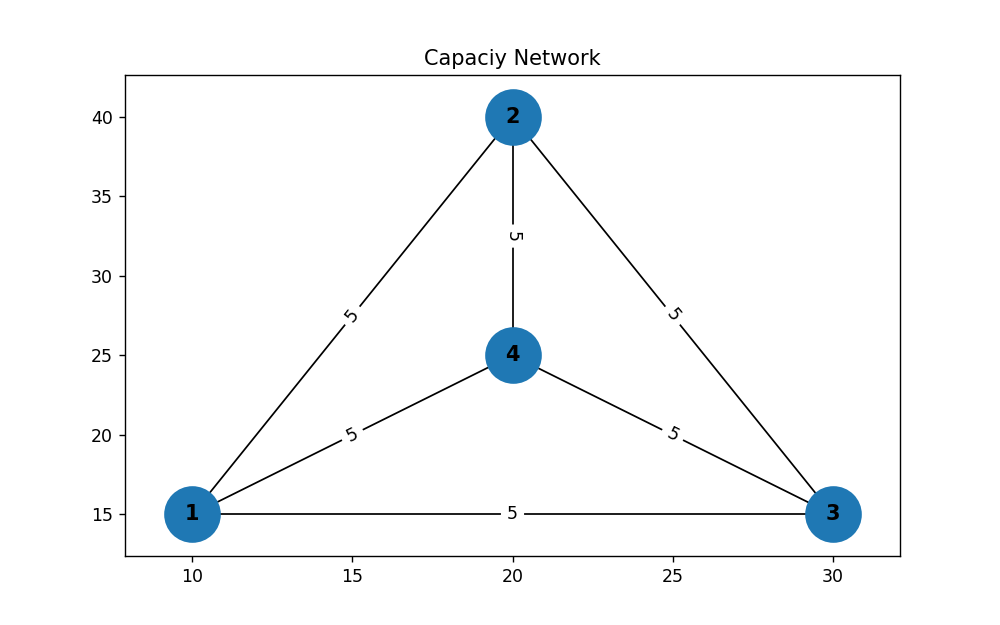

In [3]:
# 可视化
# 绘制图，当前点的位置使用绝对位置编码以获得与原论文相似的显示效果
fig, ax = plt.subplots(figsize=(8, 5))
plt.title('Capaciy Network')

edge_labels=nx.get_edge_attributes(G, 'weight')

nx_pos = {1: (10, 15), 2: (20, 40), 3: (30, 15), 4: (20, 25)}  # 绝对位置布局
nx.draw(G, nx_pos, with_labels=True, font_weight='bold', ax=ax, node_size=1000)
nx.draw_networkx_edge_labels(G,nx_pos,edge_labels=edge_labels, ax=ax)

ax.set_axis_on()
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

## 生成A矩阵
从图上搜索所有商品从源点(source)到汇点(sink)的简单路径，并按：
$$
a_{rs} = \left\{
\begin{aligned}
1 &\quad if \, C_{s} \, contains \, A_{r}, \\
0 &\quad otherwise.
\end{aligned}
\right.  \tag{1}
$$
来生成A矩阵

In [4]:
# 使用Networkx自带的BFS查找算法查找从source到sink的简单路径
# 查找后生产相应的A矩阵
A_list = []

# 记录边的数目
edge_numbers = G.number_of_edges()
# 记录路径的映射
idx = 0
path2Ci = {}
Ci2path = {}
# 记录路径对应的物品
Ci2Commodity = {}


for j in range(len(Source)):
    # 取出商品j的源点和汇点
    sources = Source[j]
    sinks = Sink[j]
    
    # 源点和汇点两两组合，生成简单路径
    for source in sources:
        for sink in sinks:
            # 寻找两点间的简单路径
            simple_paths = nx.all_simple_edge_paths(G, source, sink)
            for path in simple_paths:
                # 对每条路径创建一列
                Ai = np.zeros(edge_numbers)
                nodes = []
                # 将该列每个该路径上的边置为1
                for edge in path:
                    edge_attr = G[edge[0]][edge[1]]
                    # 取出边对应的序号
                    ei = edge_attr['ei']
                    # 对应的位置赋值1
                    Ai[ei-1] = 1
                    # 记录端点
                    nodes.append(edge[0])
                # 记录映射
                nodes.append(edge[1])
                path2Ci[', '.join(str(node) for node in nodes)] = idx
                Ci2path[idx] = ', '.join(str(node) for node in nodes)
                Ci2Commodity[idx] = j
                idx += 1
                # 路径处理完后将该列加入A中
                A_list.append(Ai)
# 将所有列拼接，并转置成论文上的A矩阵形状
A = np.vstack(A_list).T
# 记录路径的数量，记为NC
NC = len(Ci2path)
A

array([[1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.]])

In [5]:
A.shape

(6, 15)

## 创建b向量和C向量
创建b向量和C向量，为后续建立模型做准备

In [6]:
# 创建b向量和C向量
b = np.zeros(edge_numbers)
for edge in graph_edges:
    b[edge[3]-1] = edge[2]

C = np.hstack((np.ones(NC), np.zeros(edge_numbers)))

In [7]:
b, C

(array([5., 5., 5., 5., 5., 5.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 0.]))

## 建立数学模型
![线性模型](./picture/linear_model.png)

In [8]:
# 建立数学模型
# 首先，引入松弛变量，拓展A矩阵
A_extend = np.hstack((A, np.eye(edge_numbers)))

# 准备初始基矩阵，为了解决问题的一般性，选择xn+1~xn+r
B_idx = np.arange(NC,NC+edge_numbers)
# 初始B矩阵
B = A_extend[:, B_idx]

# 单纯形乘子
CB = C[B_idx]
B_inv = np.linalg.inv(B)
simplex_multipliers = np.dot(CB, B_inv) # alpha_r = CB * B-1

print("初始基矩阵B：")
print(B)
print("单纯形乘子值：")
print(simplex_multipliers)

初始基矩阵B：
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
单纯形乘子值：
[0. 0. 0. 0. 0. 0.]


## 最短路迭代
将单纯形乘子的值作为边的权重，重新生成一个图，通过最短路算法获取入基向量

In [9]:
# 输入单纯形算子、源点、汇点，返回第一个找到的路径
def get_entry_basis_vector(simplex_multipliers):
    # 新建一个图
    LG = nx.Graph()
    # 加入节点
    LG.add_nodes_from(graph_nodes)
    # 加入边和权重，注意权重为这边的单纯形算子
    for edge in graph_edges:
        LG.add_edge(edge[0], edge[1], \
            weight=simplex_multipliers[edge[3]-1], ei=edge[3])
    

    # 使用论文中的Bellman-ford算法获取最短路径
    # 但已知边里面已经没有负权了，所以用Dijkstra算法找最短路是个更好的选择
    # 为了避免重复计算相同的最短路径，可以记录下最短路的长度和对应的路径
    shortest_path_length = {}
    shortest_path = {}
    
    # 开始遍历每个商品的源点和汇点
    for j in range(len(Source)):
        sources = Source[j]
        sinks = Sink[j]
        
        for source in sources:
            for sink in sinks:
                if shortest_path.get(f"{source}->{sink}", None) is None:
                    shortest_path[f"{source}->{sink}"] = \
                       nx.bellman_ford_path(LG, source, sink)
                    shortest_path_length[f"{source}->{sink}"] = \
                       nx.bellman_ford_path_length(LG, source, sink)
                
                # 如果物品的价值不同，这边也可以改为小于对应的j物品的价值
                if shortest_path_length[f"{source}->{sink}"] < 1:
                    return shortest_path[f"{source}->{sink}"]
    # 如果没有找到，说明已经迭代到最优了，返回None值
    return None

In [10]:
# 开始迭代单纯形
max_iter = 3000
for iter_ in range(max_iter):
    print(f"--------第{iter_+1}轮迭代开始------------")
    entry_basis_vector = get_entry_basis_vector(simplex_multipliers)
    if entry_basis_vector is None:
        print("已找到最优解！")
        break
    
    # 把入基向量转换成列向量的序号
    entry_idx = path2Ci[", ".join(str(node) for node in entry_basis_vector)]
    print(f"找到入基向量x{entry_idx+1}")
    
    # 确定出基向量
    # 定位变换后的入基目标列
    entry_vector_transformed = np.dot(B_inv, A_extend[:, entry_idx])
    # 计算变换后的b列
    b_transformed = np.dot(B_inv, b)
    # 求检验数
    theta = np.zeros(edge_numbers) + np.inf
    theta[entry_vector_transformed>0] = \
       b_transformed[entry_vector_transformed>0] \
         / entry_vector_transformed[entry_vector_transformed>0]
    # 之后求检验数最小的位置，该位置对应的序号即为出基变量的序号
    position = np.argmin(theta)
    print(f"确定出基向量x{B_idx[position]+1}")
    # 出基！
    B_idx[position] = entry_idx
    
    # 善后一下，算一下B逆和单纯形乘子
    B = A_extend[:, B_idx]
    B_inv = np.linalg.inv(B)
    CB = C[B_idx]
    simplex_multipliers = np.dot(CB, B_inv)
    
    # 如果发现存在单纯形乘子中存在负数，执行预定的换基操作
    while (simplex_multipliers<0).any():
        print("单纯形乘子中存在负数，正在执行换基使其非负...")
        negative_position = np.argmin(simplex_multipliers)
        entry_idx = NC + negative_position
        # 定位变换后的入基目标列
        entry_vector_transformed = np.dot(B_inv, A_extend[:, entry_idx])
        entry_vector_transformed = np.round(entry_vector_transformed, 6)
        # 求当前的b
        b_transformed = np.dot(B_inv, b)
        # 求检验数
        theta = np.zeros(edge_numbers) + np.inf
        theta[entry_vector_transformed>0] = \
           b_transformed[entry_vector_transformed>0]\
             / entry_vector_transformed[entry_vector_transformed>0]
        # 之后求检验数最小的位置，该位置对应的序号即为出基变量的序号
        position = np.argmin(theta)

        print(f"确定出基向量x{B_idx[position]+1}")
        # 出基！
        B_idx[position] = entry_idx
        B = A_extend[:, B_idx]
        B_inv = np.linalg.inv(B)
        CB = C[B_idx]
        simplex_multipliers = np.dot(CB, B_inv)
    
    print(f"当前基:{B_idx+1}")
    print("基矩阵:")
    print(B)
    print("单纯形算子：")
    print(simplex_multipliers)

--------第1轮迭代开始------------
找到入基向量x3
确定出基向量x18
当前基:[16 17  3 19 20 21]
基矩阵:
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
单纯形算子：
[0. 0. 1. 0. 0. 0.]
--------第2轮迭代开始------------
找到入基向量x1
确定出基向量x16
当前基:[ 1 17  3 19 20 21]
基矩阵:
[[1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
单纯形算子：
[1. 0. 1. 0. 0. 0.]
--------第3轮迭代开始------------
找到入基向量x5
确定出基向量x19
当前基:[ 1 17  3  5 20 21]
基矩阵:
[[1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1.]]
单纯形算子：
[1. 0. 1. 1. 0. 0.]
--------第4轮迭代开始------------
找到入基向量x8
确定出基向量x17
当前基:[ 1  8  3  5 20 21]
基矩阵:
[[1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1.]]
单纯形算子：
[0. 1. 1. 1. 0. 0.]
--------第5轮迭代开始------------
找到入基向量x2
确定出基向量x21
当前基:[ 1  8  3  5 20  2]
基矩阵:
[[1.

## 结果展示
将标号转换为路径，并格式化路径流量分配，计算多物品最大流问题的最优值

In [11]:
X = np.dot(B_inv, b)
X, B_idx

(array([5., 5., 5., 0., 0., 5.]), array([10,  7,  2,  9, 11,  1]))

In [12]:
# 打印一下有流量的路径
for i, idx in enumerate(B_idx):
    if Ci2path.get(idx, None) is not None:
        path = Ci2path[idx].replace(", ", "→")
        if X[i] != 0:
            print(f"路径：{path}，运送物品{Ci2Commodity[idx]+1},流量为：{X[i]}")

路径：4→1，运送物品2,流量为：5.0
路径：2→3，运送物品1,流量为：5.0
路径：1→3，运送物品1,流量为：5.0
路径：1→2→4→3，运送物品1,流量为：5.0


In [13]:
# 打印最大流
print(f"最大流为{np.dot(CB, X)}")

最大流为20.0
